# **PYTHON FOR DATA SCIENCE**
### End-of-term project

## **Task 1: LLM integration**

The task involves building an AI capable of language translation.

**1.1 Single Text Translation:**

* You are asked to write a Python code using the OpenAI API to translate a given text into Vietnamese.
(You should check the text if it’s already the destination language).

* For example, translating "Hello" into Vietnamese should return "Xin chào", but “Xin chào” should
return the same.

**1.2 Multiple Texts Translation:**

* Similar to 2.1, but the input is a list of texts. The Python code should accept a list of strings and return
their translations in the specified language. 

* For instance, translating ["Hello", "I am John", “Tôi là sinh
viên”] into Vietnamese should return ["Xin chào", "Tôi tên là John", “Tôi là sinh viên”].

In [51]:
import google.generativeai as genai
from langdetect import detect
import os

In [52]:
GENAI_API_KEY = os.getenv("GENAI_API_KEY")

if GENAI_API_KEY:
    print("API Key successfully retrieved!")
else:
    print("API Key not found. Please check your environment variables.")

# print(f"Your API Key: {GENAI_API_KEY}")

API Key successfully retrieved!


In [53]:
genai.configure(api_key=GENAI_API_KEY)

# Cấu hình mô hình
model_config = {
    "temperature": 1,
    "top_p": 0.95,
    "top_k": 40,
    "max_output_tokens": 8192,
    "response_mime_type": "text/plain",
}

def get_model():
    return genai.GenerativeModel(
        model_name="gemini-2.0-flash-exp",
        generation_config=model_config,
    )

def translate_single_text(input_text):
    text = input_text["text"]
    dest_language = input_text["dest_language"]

    # Kiểm tra ngôn ngữ
    if detect(text) == dest_language:
        return {
            "input_text": text,
            "translation": text  # Giữ nguyên văn bản nếu đã đúng ngôn ngữ đích
        }

    # Lấy mô hình và thiết lập yêu cầu dịch
    model = get_model()
    prompt = f"""
        The text below may contain a mix of languages (e.g., English and Vietnamese). 
        Please translate the entire text into {dest_language}, ensuring that:
        1. The translation is natural, retains the meaning and context, and adjusts sentence structure for readability.
        2. Proper nouns (e.g., names, places) are kept unchanged unless they have a well-known equivalent in the target language.
        3. Abbreviations or technical terms are translated where possible, or kept unchanged if they do not have an equivalent.
        4. Incomplete sentences or fragments are translated as accurately as possible while preserving their context.
        5. Informal abbreviations (e.g., 'u' instead of 'you') are translated into their proper form.
        6. Conversational or exclamatory expressions retain their tone and meaning.
        Note: Return only one translation.
        Text: {text}
        """

    # Bắt đầu phiên làm việc với mô hình
    chat_session = model.start_chat()
    response = chat_session.send_message(prompt)  # Gửi prompt và nhận kết quả

    return {
        "input_text": text,
        "translation": response.text.strip()
    }


# Hàm dịch danh sách văn bản
def translate_multiple_texts(input_text):
    texts = input_text["text"]
    dest_language = input_text["dest_language"]

    # Áp dụng translate_single_text cho từng văn bản và lấy phần 'translation'
    translated_texts = [
        translate_single_text({"text": text, "dest_language": dest_language})["translation"]
        for text in texts
    ]

    # Kết hợp các văn bản gốc và phần dịch thành danh sách xuống dòng
    combined_result = "\n\n".join([
        f"input Text: {original}\ntranslation: {translated}"
        for original, translated in zip(texts, translated_texts)
    ])

    return combined_result

In [54]:
# Kiểm thử với văn bản đơn
json_1 = {
    'text': 'Tôi là student',
    'dest_language': 'vietnamese'
}

translate_single_text(json_1)

{'input_text': 'Tôi là student', 'translation': 'Tôi là sinh viên.'}

In [55]:
# Kiểm thử với danh sách văn bản
json_2 = {
    'text': ["카드로 결제할 수 있어요?", "User-friendly chatbot interface", "Tôi là student", "Bạn cảm thấy thế nào?", "Hi, Tôi rất love u", "I agree w/ u"],
    'dest_language': 'vietnamese'
}

print(translate_multiple_texts(json_2))

input Text: 카드로 결제할 수 있어요?
translation: Tôi có thể thanh toán bằng thẻ được không?

input Text: User-friendly chatbot interface
translation: Giao diện chatbot thân thiện với người dùng

input Text: Tôi là student
translation: Tôi là sinh viên.

input Text: Bạn cảm thấy thế nào?
translation: Bạn cảm thấy thế nào?

input Text: Hi, Tôi rất love u
translation: Chào bạn, tôi rất yêu bạn.

input Text: I agree w/ u
translation: Tôi đồng ý với bạn.


## **Task 2: Chatbot Development**


**Assignment Test:** Chatbot Development from Website Data. The data is at https://www.presight.io/privacy-policy.html

**2.1 Data Access and Indexing**

* Tasked with creating a chatbot, begin by web crawling the specified website to gather relevant data,
then preprocess and structure this data into a searchable index, ready for query retrieval.

* *Short version: crawling then embedding data, you can use selenium or requests*

**2.2 Chatbot Development**

* Develop a chatbot that employs natural language processing to comprehend user questions, searches
the indexed data from 2.1 for the best match, and delivers the most accurate response drawn from the
website's information.

* *Use any distance/similarity metrics to get the best match paragraph then feed to LLM to get answer*

In [56]:
import os
import time
import json
import pickle
import numpy as np

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import google.generativeai as genai

### **2.1 Data Access and Indexing**

In [57]:
# URL của trang web cần lấy dữ liệu
url = "https://www.presight.io/privacy-policy.html"

# Gửi yêu cầu GET đến trang web
response = requests.get(url)
response.raise_for_status()  

soup = BeautifulSoup(response.content, 'html.parser')

privacy_content = []

# Biến lưu trạng thái hiện tại
current_header = None  
current_subheader = None  
header_classes = None  
subheader_classes = None  
is_after_a = False  
current_paragraph = None  

# Duyệt qua các thẻ cần thiết
for tag in soup.find_all(['h2', 'p', 'i', 'li', 'a']):
    tag_classes = tag.get("class", [])  

    if tag.name == 'h2':  # Xử lý tiêu đề chính (h2)
        is_after_a = False  
        current_paragraph = None 

        if current_subheader and tag_classes == subheader_classes:
            current_subheader = {
                "subheader": tag.get_text(strip=True),
                "class": tag_classes,
                "items": []
            }
            current_header["sub_content"].append(current_subheader)
        elif current_header and not current_header["sub_content"] and header_classes != tag_classes:
            current_subheader = {
                "subheader": tag.get_text(strip=True),
                "class": tag_classes,
                "items": []
            }
            current_header["sub_content"].append(current_subheader)
        else:  # Thêm một tiêu đề chính mới
            current_header = {
                "header": tag.get_text(strip=True),
                "class": tag_classes,
                "sub_content": []
            }
            header_classes = tag_classes
            privacy_content.append(current_header)
            current_subheader = None  # Đặt lại tiêu đề phụ

    elif tag.name == 'i' and current_header is not None:  # Xử lý tiêu đề phụ (i)
        is_after_a = False  
        current_paragraph = None  # Đặt lại đoạn văn hiện tại

        current_subheader = {
            "subheader": tag.get_text(strip=True),
            "class": tag_classes,
            "items": []
        }
        current_header["sub_content"].append(current_subheader)
        subheader_classes = tag_classes  # Cập nhật lớp CSS của tiêu đề phụ hiện tại

    elif tag.name == 'a':  # Xử lý thẻ liên kết (a)
        link_text = tag.get_text(strip=True)
        link_href = tag.get("href", "")
        privacy_content.append({
            "link_text": link_text,
            "href": link_href
        })
        is_after_a = True 
        current_paragraph = None  

    elif tag.name == 'p':  # Xử lý đoạn văn (p)
        content_text = tag.get_text(strip=True)
        current_paragraph = {
            "paragraph": content_text,
            "details": []
        }
        if is_after_a:
            privacy_content.append({
                "header": None,
                "sub_content": [content_text]
            })
        elif current_subheader is not None:
            current_subheader["items"].append(current_paragraph)
        elif current_header is not None:
            current_header["sub_content"].append(current_paragraph)
        else:
            privacy_content.append({
                "header": None,
                "sub_content": [content_text]
            })

    elif tag.name == 'li':  # Xử lý danh sách (li)
        content_text = tag.get_text(strip=True)
        if current_paragraph is not None:
            # Thêm nội dung vào "details" của đoạn văn gần nhất
            current_paragraph["details"].append(content_text)
        elif current_subheader is not None:
            current_subheader["items"].append(content_text)
        elif current_header is not None:
            current_header["sub_content"].append(content_text)

            
print("DATA AFTER CRAWLING FROM WEBSITE\n")
privacy_content

DATA AFTER CRAWLING FROM WEBSITE



[{'link_text': '', 'href': '/'},
 {'header': None, 'sub_content': ['By Role']},
 {'link_text': 'Business Leaders', 'href': '/business-leaders.html'},
 {'link_text': 'Data Leaders', 'href': '/data-leaders.html'},
 {'link_text': 'Data Analysts', 'href': '/data-analysts.html'},
 {'link_text': 'Business Teams', 'href': '/business-teams.html'},
 {'header': None, 'sub_content': ['By Team']},
 {'link_text': 'Marketing', 'href': '/marketing-team.html'},
 {'link_text': 'Sales', 'href': '/sales-team.html'},
 {'link_text': 'Finance', 'href': '/finance-team.html'},
 {'link_text': 'Pricing', 'href': '/pricing.html'},
 {'link_text': 'About', 'href': '/about.html'},
 {'header': 'PRIVACY POLICY',
  'class': ['chakra-heading', 'css-dhb2ck'],
  'sub_content': [{'subheader': 'Last updated 15 Sep 2023',
    'class': ['chakra-heading', 'css-18j379d'],
    'items': [{'paragraph': 'At Presight, we are committed to protecting the privacy of our customers and visitors to our website. This Privacy Policy explai

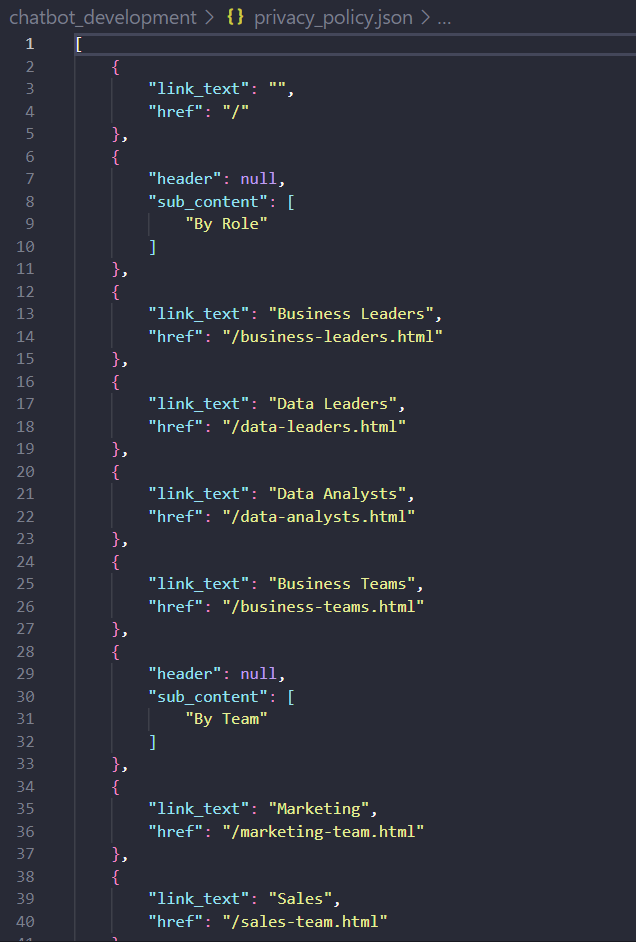

In [58]:
# Hàm kiểm tra địa lý bằng geopy
def locate(city):
    geolocator = Nominatim(user_agent="location_check")
    try:
        location = geolocator.geocode(city)
        return location is not None  # Trả về True nếu địa điểm hợp lệ
    except Exception as e:
        return False


# Hàm xóa khóa "class"
def delete_class(item):
    # Nếu là từ điển
    if isinstance(item, dict): 
        if "class" in item:  
            item.pop("class", None)
        for key, value in item.items():
            item[key] = delete_class(value)

    # Nếu là list
    elif isinstance(item, list):  
        return [delete_class(sub_item) for sub_item in item]
    return item  


# Hàm xử lý jason
def transform_data(data):

    output = []  
    more_info = {"header": "More Information", "sub_content": []}  
    location = {"header": "Location", "sub_content": []} 
    temp_by = None  # Biến lưu trữ mục chứa "By"

    for item in data:

        # Xóa class
        item = delete_class(item)

        # Bỏ link_text rỗng
        if "link_text" in item and not item["link_text"]:
            continue

        # Xóa href 
        if "href" in item:
            del item["href"]

        # xử lý phần có "All Rights Reserved"
        if "sub_content" in item and any("All Rights Reserved" in temp for temp in item["sub_content"]):
            output.append({"header": "Copyright", "sub_content": item["sub_content"]})
            continue

        # Xử lý các mục có chứa "By"
        if "sub_content" in item and "By" in item["sub_content"][0]:
            if temp_by:
                output.append(temp_by) # Nếu 'temp_py' đã có nhóm "By" thì thêm nó vào output và thêm nhóm "By" mới vào 
            temp_by = {"header": item["sub_content"][0], "sub_content": []}        
        elif "link_text" in item:  # Đưa các mục con vào nhóm "By"
            if temp_by and item["link_text"] not in ["Pricing", "About"]:
                temp_by["sub_content"].append(item["link_text"])

            # Nếu không, thêm vào danh sách "Morse Information"
            else:                
                more_info["sub_content"].append(item["link_text"])

        # Xử lý Location nếu 'sub_content' là thành phố
        elif "sub_content" in item and locate(item["sub_content"][0]):            
            location["sub_content"].extend(item["sub_content"])
        else:
            if temp_by:
                output.append(temp_by)
                temp_by = None
            output.append(item)

    if temp_by:
        output.append(temp_by)

    output.append(more_info)
    output.append(location)

    return output

# Chuyển đổi dữ liệu
data_afer_preprocess = transform_data(privacy_content)

print("DATA AFTER PREPROCESSING\n")
data_afer_preprocess

DATA AFTER PREPROCESSING



[{'header': 'By Role',
  'sub_content': ['Business Leaders',
   'Data Leaders',
   'Data Analysts',
   'Business Teams']},
 {'header': 'By Team', 'sub_content': ['Marketing', 'Sales', 'Finance']},
 {'header': 'PRIVACY POLICY',
  'sub_content': [{'subheader': 'Last updated 15 Sep 2023',
    'items': [{'paragraph': 'At Presight, we are committed to protecting the privacy of our customers and visitors to our website. This Privacy Policy explains how we collect, use, and disclose information about our customers and visitors.',
      'details': []}]}]},
 {'header': 'Information Collection and Use',
  'sub_content': [{'paragraph': 'We collect several different types of information for various purposes to provide and improve our Service to you.',
    'details': []}]},
 {'header': 'Types of Data Collected',
  'sub_content': [{'subheader': 'Personal Data',
    'items': [{'paragraph': 'While using our Service, we may ask you to provide us with certain personally identifiable information that can

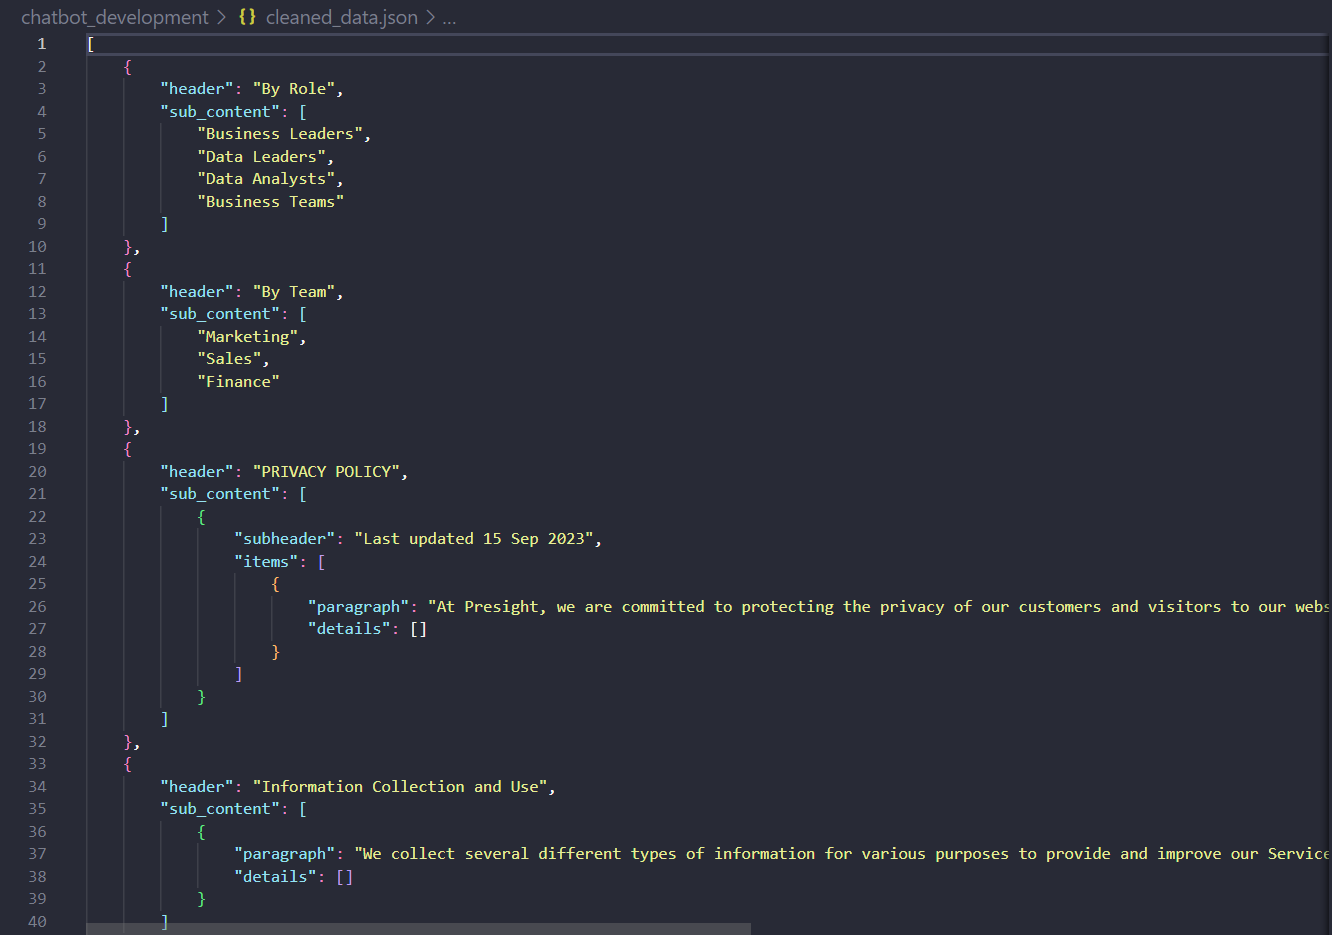

In [59]:
# Hàm trích xuất văn bản từ sub_content
def extract_text_from_subcontent(subcontent):
    """
    subcontent có thể là:
    - Một danh sách các chuỗi
    - Một danh sách các dict (có thể chứa subheader, paragraph, items, details, v.v.)
    Hàm này trả về danh sách các đoạn văn bản.
    """
    results = []

    # Trường hợp sub_content toàn chuỗi
    if all(isinstance(item, str) for item in subcontent):
        results.extend(subcontent)
    else:
        # Trường hợp sub_content chứa các dict
        for elem in subcontent:
            if isinstance(elem, dict):
                # Xử lý subheader
                if "subheader" in elem and elem["subheader"]:
                    results.append(elem["subheader"])
                # Xử lý paragraph
                if "paragraph" in elem and elem["paragraph"]:
                    results.append(elem["paragraph"])
                # Xử lý items
                if "items" in elem and isinstance(elem["items"], list):
                    for item in elem["items"]:
                        if "paragraph" in item and item["paragraph"]:
                            results.append(item["paragraph"])
                        if "details" in item and item["details"]:
                            results.extend(item["details"])
                # Xử lý details
                if "details" in elem and elem["details"]:
                    results.extend(elem["details"])

    return results

# Hàm tạo embeddings và lưu vào file pickle
def create_indexed_data(data, model, output_pickle):
    chunks = []
    for idx, item in enumerate(data):
        # Trích xuất header và nội dung
        header_name = item["header"]
        extracted_text = extract_text_from_subcontent(item["sub_content"])
        combined_text = f"{header_name}\n" + "\n".join(extracted_text)
        chunks.append({
            "header_index": idx,
            "header": header_name,
            "text": combined_text
        })

    # Tạo embeddings cho các đoạn văn bản
    texts = [chunk["text"] for chunk in chunks]
    embeddings = model.encode(texts, show_progress_bar=True)

    # Lưu kết quả
    indexed_data = []
    for i, emb in enumerate(embeddings):
        indexed_data.append({
            "header_index": chunks[i]["header_index"],
            "header": chunks[i]["header"],
            "text": chunks[i]["text"],
            "embedding": emb
        })

    # Lưu indexed data ra file pickle
    with open(output_pickle, "wb") as f:
        pickle.dump(indexed_data, f)

    print(f"Indexed {len(indexed_data)} chunks.")
    return indexed_data


In [60]:
if __name__ == "__main__":
    # Load mô hình SentenceTransformer
    model = SentenceTransformer("all-MiniLM-L6-v2")
    
    # File pickle output
    output_pickle = "indexed_data.pkl"

    # Tạo indexed data
    data_final = create_indexed_data(data_afer_preprocess, model, output_pickle)


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Indexed 23 chunks.


In [61]:
print("DATA FOR CHATBOT\n")
data_final

DATA FOR CHATBOT



[{'header_index': 0,
  'header': 'By Role',
  'text': 'By Role\nBusiness Leaders\nData Leaders\nData Analysts\nBusiness Teams',
  'embedding': array([-1.18501727e-02,  4.14281003e-02, -1.62397791e-02,  4.56051566e-02,
         -6.30490109e-02, -3.65320295e-02, -1.25255119e-02, -1.59797147e-02,
         -7.91616179e-03,  2.32126303e-02, -2.18259618e-02,  1.89398862e-02,
          6.11356050e-02,  3.04035041e-02,  1.45449387e-02,  3.98720689e-02,
         -4.34052981e-02, -1.00315316e-02, -7.07916394e-02, -1.18882805e-01,
         -9.72365066e-02, -1.09466955e-01, -6.91230297e-02, -5.42902276e-02,
         -2.42529064e-02, -2.09344202e-03, -2.55639059e-03, -3.91704217e-02,
          9.92223714e-03, -6.47066385e-02, -6.42732754e-02, -7.67711848e-02,
          8.40578973e-02,  8.40199888e-02, -4.67182957e-02,  2.83425543e-02,
          2.99434196e-02,  2.90693752e-02,  6.78663403e-02,  5.69281504e-02,
         -4.39242683e-02,  1.58041588e-03, -6.93218186e-02, -2.43740156e-02,
         -2.

### **2.2 Chatbot Development**

In [62]:
# Hàm tìm các chunk phù hợp nhất với câu hỏi người dùng
def find_best_chunks(question, model, indexed_data, header_weight=3.0, content_weight=2.0, k=2):
    """
    Tìm các đoạn văn phù hợp nhất bằng cách ưu tiên header, sau đó fallback về nội dung.
    - Sử dụng trọng số cho header và nội dung.
    - Trả về top-k đoạn phù hợp.
    """
    # Tạo embedding cho câu hỏi
    question_embedding = model.encode([question])

    # Tính toán độ tương đồng cho header và nội dung
    header_embeddings = np.vstack([item["embedding"] for item in indexed_data])
    content_embeddings = np.vstack([model.encode([item["text"]])[0] for item in indexed_data])

    header_similarities = cosine_similarity(question_embedding, header_embeddings)[0]
    content_similarities = cosine_similarity(question_embedding, content_embeddings)[0]

    # Tính điểm tổng hợp với trọng số
    combined_scores = header_weight * header_similarities + content_weight * content_similarities

    # Lấy top-k đoạn văn bản
    sorted_indices = np.argsort(combined_scores)[::-1]
    top_indices = sorted_indices[:k]

    return [indexed_data[i] for i in top_indices]


In [63]:
# Hàm gửi nội dung tới Gemini và lấy câu trả lời
def generate_answer(question, chunks):
    """
    Kết hợp các đoạn văn bản và gửi tới Gemini để sinh câu trả lời.
    """
    context = "\n\n---\n\n".join([chunk["text"] for chunk in chunks])
    prompt = f"""
You are an AI assistant. Use the provided context to answer the user's question in English.

Context:
{context}

User's Question:
{question}

Answer in natural language:
"""
    # Gửi prompt tới Gemini
    chat_session = genai.GenerativeModel(model_name="gemini-2.0-flash-exp").start_chat()
    response = chat_session.send_message(prompt)
    return response.text.strip()


In [64]:
# Hàm giao diện chatbot CLI
def chatbot(model, indexed_data):
    print("\nHello! Ask me anything about the privacy policy. Type 'exit' to quit.")
    while True:
        user_question = input("\nYour question: ")
        if user_question.lower() == "exit":
            print("Goodbye!")
            break

        # Bắt đầu tính thời gian
        start_time = time.time()

        # Tìm các đoạn phù hợp nhất
        best_chunks = find_best_chunks(user_question, model, indexed_data, header_weight=3.0, content_weight=2.0, k=3)
        print(f"Found relevant chunks:\n{[chunk['header'] for chunk in best_chunks]}")

        # Gửi câu hỏi và nhận câu trả lời từ Gemini
        answer = generate_answer(user_question, best_chunks)

        # Kết thúc tính thời gian
        end_time = time.time()
        response_time = end_time - start_time

        # Hiển thị câu trả lời và thời gian phản hồi
        print("\nYour question:", user_question)
        print("\nAnswer:", answer)
        print(f"Response time: {response_time:.2f} seconds")


In [65]:
if __name__ == "__main__":

    GENAI_API_KEY = os.getenv("GENAI_API_KEY")
    if GENAI_API_KEY:
        print("API Key successfully retrieved!")
    else:
        print("API Key not found. Please check your environment variables.")
    # print(f"Your API Key: {GENAI_API_KEY}")

    genai.configure(api_key=GENAI_API_KEY)

    # Load mô hình và indexed data
    model = SentenceTransformer("all-MiniLM-L6-v2")
    with open("indexed_data.pkl", "rb") as f:
        indexed_data = pickle.load(f)

    # Chạy chatbot
    chatbot(model, indexed_data)

API Key successfully retrieved!

Hello! Ask me anything about the privacy policy. Type 'exit' to quit.
Found relevant chunks:
['PRIVACY POLICY', 'Contact Us', 'More Information']

Your question: What is policy?

Answer: The policy is a Privacy Policy that explains how Presight collects, uses, and discloses information about their customers and website visitors.
Response time: 2.58 seconds
Found relevant chunks:
['PRIVACY POLICY', 'Changes to Privacy Policy', 'Monitoring and Enforcement']

Your question: When is the latest update?

Answer: The latest update to the privacy policy was on September 15, 2023.
Response time: 1.61 seconds
Found relevant chunks:
['Contact Us', 'PRIVACY POLICY', 'Changes to Privacy Policy']

Your question: What email can I use to contact Presight about the Privacy Policy?

Answer: You can contact Presight about their Privacy Policy by sending an email to presight@presight.io.
Response time: 1.93 seconds
Goodbye!


### **2.3 Demo chatbot interface**

Nhóm em đã phát triển interface chatbot nhằm tạo điều kiện thuận lợi cho người dùng trong việc truy vấn thông tin và tương tác trực tiếp với chatbot. Giao diện này được thiết kế để tối ưu hóa trải nghiệm người dùng, giúp việc trò chuyện với chatbot trở nên dễ dàng và hiệu quả hơn. 

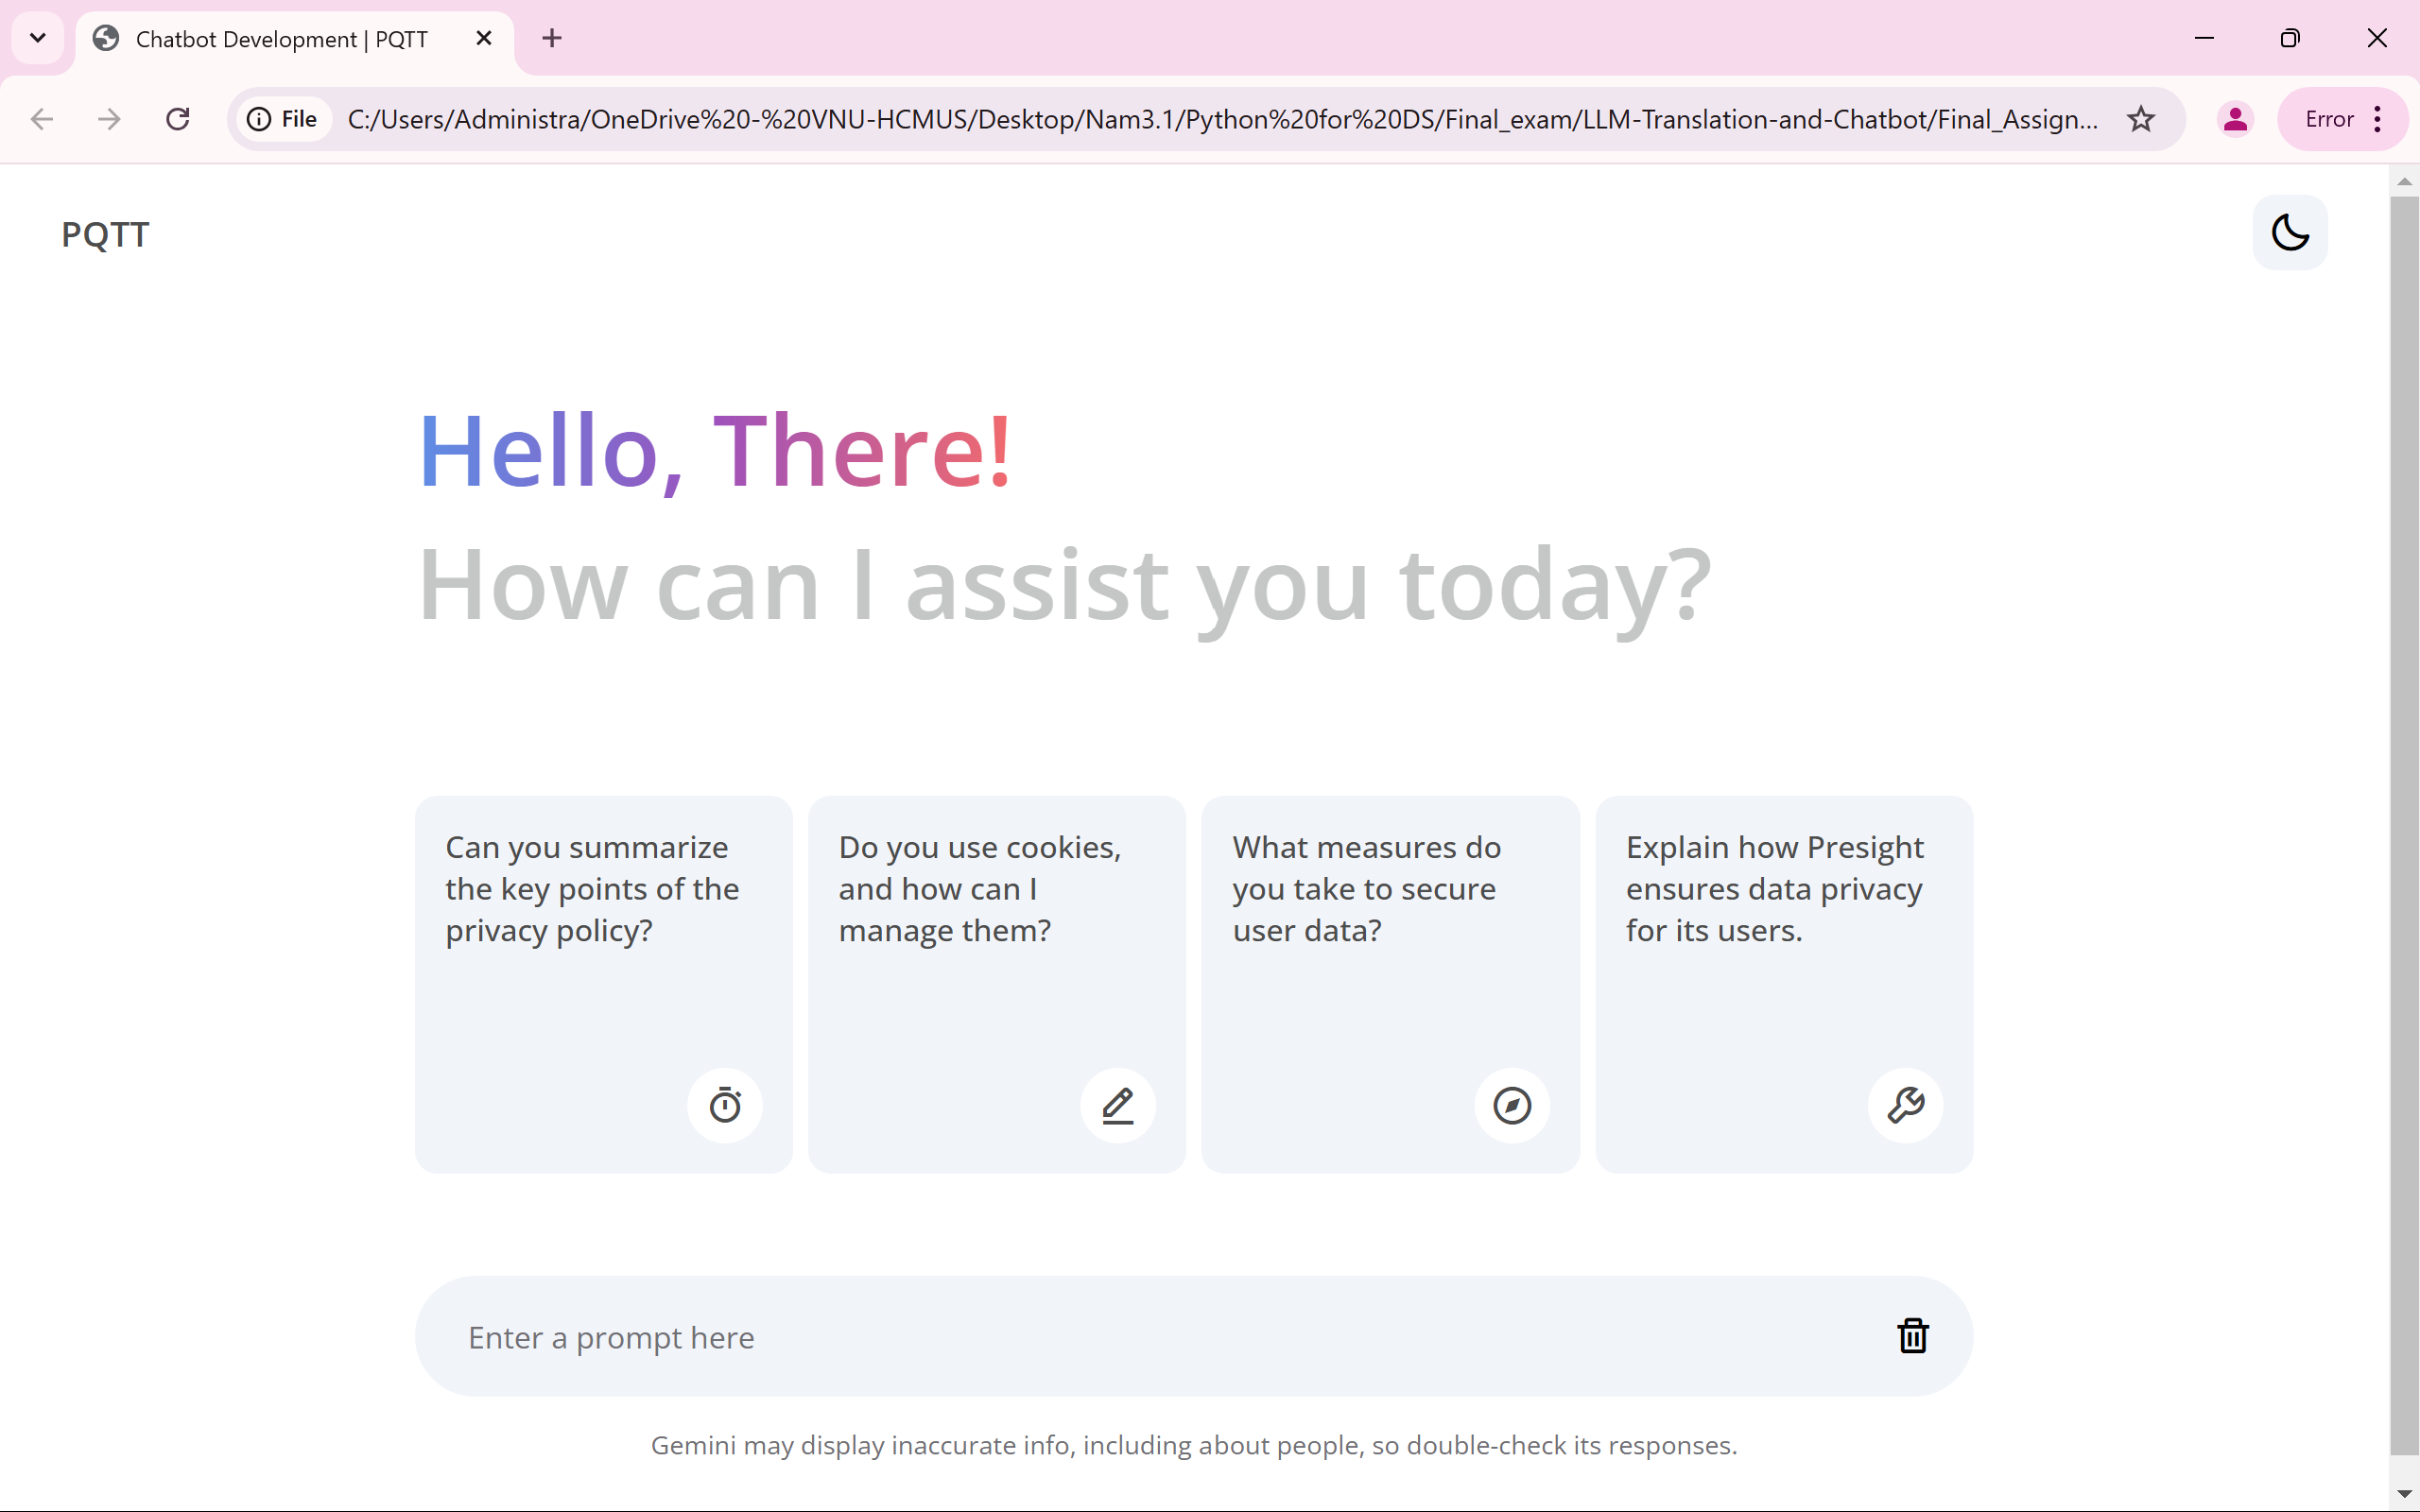

### **video demo đính kèm trong file**